In [21]:
from numpy.linalg import norm
from gensim.models import FastText
import sys
import os.path as op
import random
import pandas as pd
import numpy as np 

def kmeans(data, k, maxIterations, distance="cosinus", vectorColumn="text_vec"):

    # Initialize centroids randomly
    centroids = initialise_centroids(np.asarray(data[vectorColumn].values.tolist()), k)   # [ arr, arr, .., arr ]

    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = [np.zeros((200,)) for i in range(k)]
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations, maxIterations):
        print("Iterations:", iterations)
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        data["label"] = data[vectorColumn].map(lambda d: getLabelForEachDataPoint(d, centroids, distance=distance)).astype('category')
        #labels = getLabelForEachDataPoint(data, centroids)   

        # Assign centroids based on datapoint labels
        centroids = data.groupby(by="label").apply(lambda value: getMean(value, vectorColumn))#.mean()

    # We can get the labels too by calling getLabels(dataSet, centroids)
    return data


def getMean(data, vectorColumn):
    matrix_form = np.asarray(data[vectorColumn].values.tolist())
    return np.sum(matrix_form,axis=0) / matrix_form.shape[0]


def updateCentroids(data, labels, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

    # recalculate centroids
    index = 0
    for cluster in labels:
        old_centroids[index] = data[index]
        data[index] = np.mean(cluster, axis=0).tolist()
        index += 1

def initialise_centroids(data, k):
    random_indices = random.sample(range(len(data)), k)
    return [data[i] for i in random_indices]


def shouldStop(oldCentroids, centroids, iterations, maxIterations):
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
    if iterations > maxIterations: return True
    return all([(centroids[i] == oldCentroids[i]).all() for i in range(len(centroids))])#(oldCentroids == centroids).all()

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))


# Calculates euclidean distance between
# a data point and all the available cluster
# centroids.      
def getLabelForEachDataPoint(tweet_vec, centroids, distance="cosinus"):
     
    if distance == "cosinus": return max([(i, cosinus_similarity(tweet_vec, center)) for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    elif distance == "euclidean" : return min([(i, np.linalg.norm(tweet_vec-center))for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    else: print("ERROR: Wrong distance meausure!")
        
        
        
        
        
def preprocess(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

In [39]:


basename = "/Users/Adrian/Desktop/WDDS/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

data = pd.read_parquet("/Users/Adrian/Desktop/WDDS/Models_Data/tweets_10042019/matching-tweets_diab_noRetweetsDupl_personal_noJokes_LocationUS_geoCityCodeNotNull_Gender_TypeDiab.parquet", columns=["id", "text", "user_name", "gender", "typeDiabetes"])
model = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_09112018.model")

#df = readFile(filename, columns="id, created_at, text, user_screen_name, user_name")
#df = df.reset_index("user_name", drop=True)#.reset_index(drop=True)
#data = data.reset_index(drop=True)

data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess(tweet), model))
data["prep"] = data.text.map(lambda tweet: preprocess(tweet))
data.head()


,id,text,user_name,gender,typeDiabetes,text_vec,prep
0,9.962099e+17,@KneWKeeD Diabetes right there! And kids will ...,,2,0,"[0.21440409, -0.17444175, -0.021668807, 0.1690...","[right, kids, want, go, time, sad, fan, lived]"
1,1.039292e+18,Last year I was told I was borderline diabetic...,Autumn,2,0,"[0.16643897, -0.29989997, -0.16051055, 0.14155...","[last, year, told, borderline, insulin, resist..."
2,1.086002e+18,@LindsayAWatts @fox5dc Maybe the kid is diabet...,!,2,0,"[0.15877365, -0.30737287, -0.17500159, 0.16021...","[maybe, kid, undergoing, severe, ketoacidosis,..."
3,9.552752e+17,i dont support racists but y’all....... tell m...,"!?]3"" bogle",2,0,"[0.09505443, -0.19526166, -0.092955865, 0.1770...","[support, racists, tell, t1d, palette]"
4,8.928878e+17,so type 1 diabetes https://t.co/NFGY1vkOmx,"!?]3"" bogle",2,2,"[-0.09210473, -0.3788329, -0.17019872, -0.0547...","[type, one]"


In [40]:
def preprocess(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic", "#dsma"]]
    return tweet


dsma_data = data[data['text'].str.contains("#dsma")]
dsma_data["text_vec"] = dsma_data.text.map(lambda tweet: tweet_vectorizer(preprocess(tweet), model))
print(dsma_data.shape)
dsma_data.head()

(6930, 7)


/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,text,user_name,gender,typeDiabetes,text_vec,prep
1717,9.056050e+17,@SweeterCherise Q2: when your friends tell you...,=ger=,2,0,"[0.062331498, -0.2344149, 0.09847741, 0.186458...","[q2, friends, tell, eat, right]"
1721,9.056120e+17,@DiabetesSocMed i have these kinda days but i ...,=ger=,2,0,"[0.14181024, -0.28045103, 0.08644849, 0.059381...","[kinda, days, give]"
1726,9.056142e+17,@DiabetesSocMed same to you. #dsma,=ger=,2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[]
1748,9.056020e+17,@DiabetesSocMed i have type 2. how cute is tha...,=ger=,2,2,"[-0.0053012767, -0.37224594, 0.08820477, 0.202...","[type, two, cute]"
1749,9.208286e+17,@DiabetesSocMed i just tell people it's a thin...,=ger=,2,0,"[0.26496866, -0.44536093, -0.09964534, 0.27228...","[tell, people, thinking, disease, constantly, ..."


In [22]:
MAX_ITERATIONS = 300

Ncluster = 20

res_dsma=kmeans(dsma_data, Ncluster, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
res_dsma.head()

Iterations: 0


/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34


,id,text,user_name,gender,typeDiabetes,text_vec,prep,label
1717,9.056050e+17,@SweeterCherise Q2: when your friends tell you...,=ger=,2,0,"[0.09865463, -0.25056246, 0.12133771, 0.078033...","[q2, friends, tell, eat, right, #dsma]",18
1721,9.056120e+17,@DiabetesSocMed i have these kinda days but i ...,=ger=,2,0,"[0.17642525, -0.2931633, 0.12374618, -0.071487...","[kinda, days, give, #dsma]",18
1726,9.056142e+17,@DiabetesSocMed same to you. #dsma,=ger=,2,1,"[0.28027025, -0.3313002, 0.23563924, -0.464093...",[#dsma],6
1748,9.056020e+17,@DiabetesSocMed i have type 2. how cute is tha...,=ger=,2,2,"[0.066091605, -0.36200953, 0.12506339, 0.03572...","[type, two, cute, #dsma]",19
1749,9.208286e+17,@DiabetesSocMed i just tell people it's a thin...,=ger=,2,0,"[0.26688138, -0.43110335, -0.05773477, 0.18023...","[tell, people, thinking, disease, constantly, ...",18


In [50]:
MAX_ITERATIONS = 120

Ncluster = 100

res=kmeans(data, Ncluster, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
res.head()


Iterations: 0
Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34
Iterations: 35
Iterations: 36
Iterations: 37
Iterations: 38
Iterations: 39
Iterations: 40
Iterations: 41
Iterations: 42
Iterations: 43
Iterations: 44
Iterations: 45
Iterations: 46
Iterations: 47
Iterations: 48
Iterations: 49
Iterations: 50
Iterations: 51
Iterations: 52
Iterations: 53
Iterations: 54
Iterations: 55
Iterations: 56
Iterations: 57
Iterations: 58
Iterations: 59
Iterations: 60
Iterations: 61
Iterations: 62
Iterations: 63
Iterations: 64
Iterations: 65
Iterations: 66
Itera

,id,text,user_name,gender,typeDiabetes,text_vec,label
0,9.962099e+17,@KneWKeeD Diabetes right there! And kids will ...,,2,0,"[0.06726977, -0.23294397, -0.005790491, 0.1207...",78
1,1.039292e+18,Last year I was told I was borderline diabetic...,Autumn,2,0,"[0.109262824, -0.24675807, -0.06214569, 0.1665...",44
2,1.086002e+18,@LindsayAWatts @fox5dc Maybe the kid is diabet...,!,2,0,"[0.14039952, -0.2876961, -0.07606644, 0.198472...",47
3,9.552752e+17,i dont support racists but y’all....... tell m...,"!?]3"" bogle",2,0,"[0.002957104, -0.20982343, 0.011950261, 0.1875...",38
4,8.928878e+17,so type 1 diabetes https://t.co/NFGY1vkOmx,"!?]3"" bogle",2,2,"[-0.035218835, -0.32490304, -0.09288238, 0.152...",39


(6930, 200)


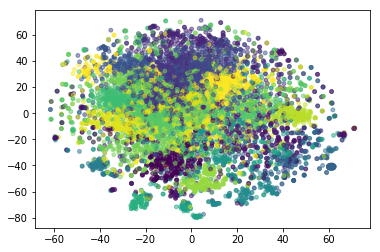

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
model_TSNE = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res_dsma["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model_TSNE.fit_transform(X_tsne)
 
plt.scatter(Y[:, 0], Y[:, 1], c=res_dsma["label"], s=15,alpha=.5)
 

#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
plt.show()

In [42]:
def calc_distance_to_groupCenter(group, topN, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    
    group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    
    print("------")
    print("Label:", group["label"].values[0], "(Number tweets: {})".format(group.shape[0]))
    print("------")
    for i, row in group.head(topN).iterrows():
        print(row["text"])
        print()   
    
    return(group)



def print_closest_tweets_to_groupCenter(data, topN, vectorColumn="text_vec"):

    print("================")
    print("Closest tweets:")
    print("================")
    data = data.groupby(by="label", as_index=False) \
              .apply(lambda data: calc_distance_to_groupCenter(data, topN,"text_vec")) \
              .reset_index(drop=True)
    return(data)

    
#res1 = print_closest_tweets_to_groupCenter(res, 10, "text_vec")
#res1.head()

res_dsma1 = print_closest_tweets_to_groupCenter(res_dsma, 10, "text_vec")
res_dsma1.head()

Closest tweets:
------
Label: 0 (Number tweets: 351)
------
It's nearly that time, so let me finish up tonight by saying thanks to everyone for participating in a lively chat tonight #dsma

Hi all!  I’ve been offline this whole last week at the #cwdffl2017 conference, so thanks for letting me jump back in with tonight’s #dsma. ☺

If we weren’t delayed I’d be landing now. I miss my bed.  Good chat tonight everyone. #dsma

Good evening, everyone! Tonight’s chat will not be moderated. Please feel free to chat. We will be back to regular convo next week. #dsma

Thanks to everyone for participating in a fun chat.  I will miss you all terribly until next Wednesday #dsma

@tmana We see you the following week. Thank you for chatting tonight. #dsma

@DiabetesSocMed Ask me next week. I think I just tasted my first peer support with happening onto this chat tonight. #dsma

Good evening, everyone! There will not be a moderates chat tonight.  We’ll see you next week. #dsma

@Donna_Apperson Thank yo

------
Label: 14 (Number tweets: 658)
------
@DiabetesSocMed A7. We need to do grassroots. Outreach and education. Maybe have a non diabetic close friend join us one Wednesday. #dsma

Q3. I will say that the #DOC culture has impacted me in many ways... advice, inclusion, lots of education... #dsma

A4: let's just go about and change the entire teen years' approach- parents &amp; HCP's. (Soapbox). But listen to me (us). #dsma

Q5. From advertising, I learn a product exists. From HCPs, a little more.  From the #DOC &amp; friends, all the important stuff #dsma

Closing: Forber thankful for this community. It’s nice knowing there is a computer screen full of people who get it.  #dsma

Closing thoughts: these chats always seem to be about just the right topic when I need it. Loved having NP students join #dsma

Quick note: If you want to connect with someone offline, you should just ask.  Not everyone has high level of engagement, but many do #dsma

Q1: Just looked up a USA Today article fr

,id,text,user_name,gender,typeDiabetes,text_vec,prep,label,cos_similarity_to_center
0,1.002007e+18,"It's nearly that time, so let me finish up ton...",StephenS,0,1,"[0.18640073, -0.42844197, 0.08766787, 0.059608...","[nearly, time, let, finish, tonight, saying, t...",0,0.956010
1,8.853036e+17,Hi all! I’ve been offline this whole last wee...,DiabetesSocMedAdvoca,2,1,"[0.17808384, -0.3499448, -0.05999764, 0.072355...","[hi, offline, whole, last, week, #cwdffl2017, ...",0,0.950042
2,1.045130e+18,If we weren’t delayed I’d be landing now. I mi...,Heather McCullen,1,1,"[0.22564319, -0.23434226, 0.08518431, 0.151582...","[delayed, would, landing, miss, bed, good, cha...",0,0.949916
3,9.030572e+17,"Good evening, everyone! Tonight’s chat will no...",Cherise/LADA,2,1,"[0.28438175, -0.3099109, 0.087430924, 0.094266...","[good, evening, everyone, tonight, chat, moder...",0,0.949851
4,9.233689e+17,Thanks to everyone for participating in a fun ...,DiabetesSocMedAdvoca,2,1,"[0.17450514, -0.30039984, 0.0396401, 0.1194296...","[thanks, everyone, participating, fun, chat, m...",0,0.948509


In [43]:
from collections import Counter
import operator

topN = 10


def global_term_frequency(data, textColumn):
    word_counter = {}
    for i, row in data.iterrows():
        for word in preprocess(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1    

    return word_counter

def topN_keywords(group, topN, textColumn, global_term_frequency_dict):

    
    N_group = group.shape[0]
    
    print("Calculate topWords for group {}..".format(group["label"].values[0]))
    word_counter = {}
    for i, row in group.iterrows():
        for word in preprocess(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1
         
    topKeywords = dict(sorted(word_counter.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str = ", ".join(str(e) for e in topKeywords.keys())

    #print("Calculate topWords inverse (N_group / N_global) for group {}..".format(group["label"].values[0]))
    word_counter_inv = {k: v / global_term_frequency_dict[k] for k, v in word_counter.items() if v > 100} # consider only words that occur often in a group, otherwise there is too much noise
    
    
    topKeywords_inv = dict(sorted(word_counter_inv.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str_inv = ", ".join(str(e) for e in topKeywords_inv.keys())

    # Take only closest tweet to center for one user to avoid that all tweets we put in the dataframe come from the same user
    grp_oneTweetPerUser = group.groupby(by="user_name", as_index=False).apply(lambda grp_user: grp_user.head(1))
    grp_oneTweetPerUser.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    text = ""
    for index, row in grp_oneTweetPerUser.head(10).iterrows():
        text += row["text"]+" (cos sim. to center: "+str("%.2f" % row["cos_similarity_to_center"])+")  #  .=.=.=. NEXT.=.=.=.     "

    # create percentages of Male, Female, Unknown in groups
    gender_count = group.gender.value_counts()
    if 0 not in gender_count.index: gender_count[0] = 0
    if 1 not in gender_count.index: gender_count[1] = 0
    if 2 not in gender_count.index: gender_count[2] = 0

    gender_freq_M = gender_count[0]
    gender_freq_F = gender_count[1]
    gender_freq_U = gender_count[2]
    
    gender_perc_M = "%.2f" % (gender_count[0] / N_group)
    gender_perc_F = "%.2f" % (gender_count[1] / N_group)
    gender_perc_U = "%.2f" % (gender_count[2] / N_group)

#    gender_freq = ("M: "+str(gender_count[0])
#                 +" F: "+str(gender_count[1])
#                 +" U: "+str(gender_count[2]))

#    gender_perc = ("M: "+str("%.2f" % (gender_count[0] / N_group))
#                 +"% F: "+str("%.2f" % (gender_count[1] / N_group))
#                 +"% U: "+str("%.2f" % (gender_count[2] / N_group))+"%")

    # create percentages non diab, type 1 or type 2
    typeDiab_count = group.typeDiabetes.value_counts()
    if 0 not in typeDiab_count.index: typeDiab_count[0] = 0
    if 1 not in typeDiab_count.index: typeDiab_count[1] = 0
    if 2 not in typeDiab_count.index: typeDiab_count[2] = 0

    typeDiab_freq_noDiab = typeDiab_count[0]
    typeDiab_freq_type1 = typeDiab_count[1]
    typeDiab_freq_type2 = typeDiab_count[2]
    
    typeDiab_perc_noDiab = "%.2f" % (typeDiab_count[0] / N_group)
    typeDiab_perc_type1 = "%.2f" % (typeDiab_count[1] / N_group)
    typeDiab_perc_type2 = "%.2f" % (typeDiab_count[2] / N_group)
    
#    typeDiab_freq = ("noDiab: "+str(typeDiab_count[0])
#                 +" type1: "+str(typeDiab_count[1])
#                 +" type2: "+str(typeDiab_count[2]))
        
#    typeDiab_perc = ("noDiab: "+str("%.2f" % (typeDiab_count[0] / N_group))
#                 +"% type1: "+str("%.2f" % (typeDiab_count[1] / N_group))
#                 +"% type2: "+str("%.2f" % (typeDiab_count[2] / N_group))+"%")

    return pd.DataFrame({"Topic": [group["label"].values[0]], "Frequency": N_group,
                         "male_freq" : gender_freq_M, "female_freq":gender_freq_F, "unknown_freq": gender_freq_U,
                         "male_prop" : gender_perc_M, "female_prop":gender_perc_F, "unknown_prop": gender_perc_U,
                         "noDiab_freq" : typeDiab_freq_noDiab, "type1_freq":typeDiab_freq_type1, "type2_freq": typeDiab_freq_type2,
                         "noDiab_prop" : typeDiab_perc_noDiab, "type1_prop":typeDiab_perc_type1, "type2_prop": typeDiab_perc_type2,
                         "topWords" : topKeywords_str, "topWords_inverse":topKeywords_str_inv, 
                         "SampleTexts" : text})
                
# General solution:
#global_term_frequency_dict = global_term_frequency(res, "text")
#print("N terms:", len(global_term_frequency_dict))

#topKeywords = res1.groupby(by="label", as_index=False) \
#              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
#              .reset_index(drop=True)
#topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.4f" % (freq/res.shape[0]))

# for dsma
global_term_frequency_dict = global_term_frequency(res_dsma, "text")
print("N terms:", len(global_term_frequency_dict))

topKeywords = res_dsma1.groupby(by="label", as_index=False) \
              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
              .reset_index(drop=True)

topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.4f" % (freq/res_dsma.shape[0]))
topKeywords = topKeywords[["Topic", "Frequency", "Proportion", 
                           "male_freq", "female_freq", "unknown_freq",
                           "male_prop", "female_prop", "unknown_prop",
                           "noDiab_freq", "type1_freq", "type2_freq",
                           "noDiab_prop", "type1_prop", "type2_prop",
                           "topWords", "topWords_inverse", "SampleTexts"]]


topKeywords.head()

N terms: 7847
Calculate topWords for group 0..
Calculate topWords for group 0..
Calculate topWords for group 1..
Calculate topWords for group 2..
Calculate topWords for group 3..
Calculate topWords for group 4..
Calculate topWords for group 5..
Calculate topWords for group 6..
Calculate topWords for group 7..
Calculate topWords for group 8..
Calculate topWords for group 9..
Calculate topWords for group 10..
Calculate topWords for group 11..
Calculate topWords for group 12..
Calculate topWords for group 13..
Calculate topWords for group 14..
Calculate topWords for group 15..
Calculate topWords for group 16..
Calculate topWords for group 17..
Calculate topWords for group 18..
Calculate topWords for group 19..


,Topic,Frequency,Proportion,male_freq,female_freq,unknown_freq,male_prop,female_prop,unknown_prop,noDiab_freq,type1_freq,type2_freq,noDiab_prop,type1_prop,type2_prop,topWords,topWords_inverse,SampleTexts
0,0,351,0.0506,81,114,156,0.23,0.32,0.44,13,338,0,0.04,0.96,0.00,"tonight, chat, thanks, us, everyone, thank, we...",tonight,"It's nearly that time, so let me finish up ton..."
1,1,493,0.0711,147,228,118,0.30,0.46,0.24,104,383,6,0.21,0.78,0.01,"yes, q3, agree, well, :), a5, love, question, ...",,Q3 Thinking life is good! Believing the usual ...
2,2,200,0.0289,77,101,22,0.39,0.51,0.11,32,166,2,0.16,0.83,0.01,"insulin, insurance, pump, cgm, q2, q5, supplie...",,Totally agree RT @ChelcieRice: Q5 Glucose tabs...
3,3,662,0.0955,284,276,102,0.43,0.42,0.15,114,539,9,0.17,0.81,0.01,"one, think, q1, like, people, q3, much, really...",,Q3. To consistently pre-bolus (this one goes f...
4,4,466,0.0672,176,198,92,0.38,0.42,0.20,93,363,10,0.20,0.78,0.02,"q1, bg, q2, low, time, q4, pump, q3, cgm, blood",,@DiabetesSocMed Q1: depends! Tweaking basals a...


In [44]:
for i, row in topKeywords.iterrows():
    print("Topic:", row["Topic"])
    print("top keywords:", row["topWords"])
    print("top keywords inverse:", row["topWords_inverse"])
    print()

Topic: 0
top keywords: tonight, chat, thanks, us, everyone, thank, week, join, hi, hope
top keywords inverse: tonight

Topic: 1
top keywords: yes, q3, agree, well, :), a5, love, question, q5, q1
top keywords inverse: 

Topic: 2
top keywords: insulin, insurance, pump, cgm, q2, q5, supplies, get, need, one
top keywords inverse: 

Topic: 3
top keywords: one, think, q1, like, people, q3, much, really, many, also
top keywords inverse: 

Topic: 4
top keywords: q1, bg, q2, low, time, q4, pump, q3, cgm, blood
top keywords inverse: 

Topic: 5
top keywords: years, two, three, ago, day, one, five, minutes, four, last
top keywords inverse: 

Topic: 6
top keywords: #aade17, love, q2, yes, :), q4, q3, tonight, q5, interesting
top keywords inverse: 

Topic: 7
top keywords: true, false, q3, january, truth, always, q2, sad, q4, things
top keywords inverse: 

Topic: 8
top keywords: sorry, late, hi, hear, :), hope, good, glad, missed, hello
top keywords inverse: 

Topic: 9
top keywords: welcome, thank, t

In [45]:
#topKeywords.to_csv("MostRepresentativeTweets_K_{}.csv".format(Ncluster), sep=";")
topKeywords.to_csv("dsmaTweets_K_{}_sampleTweetsFromDifferentUsers.csv".format(Ncluster), sep=";")


In [8]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, metric="cosine")
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model.fit_transform(X_tsne)
 


(164466, 200)


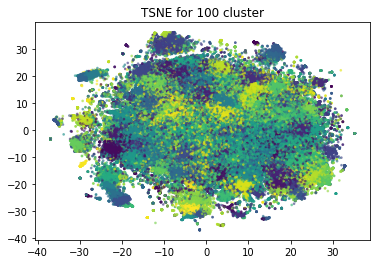

In [13]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], c=res["label"], s=3,alpha=.5)

plt.title("TSNE for {} cluster".format(Ncluster))
plt.savefig("TSNE_K_{}".format(Ncluster))
#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
#plt.show()

In [33]:
topN = 10


def global_term_frequency(data, textColumn):
    word_counter = {}
    for i, row in data.iterrows():
        for word in preprocess(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1    

    return word_counter

def topN_keywords(group, topN, textColumn):
    
    grp_oneTweetPerUser = group.groupby(by="user_name", as_index=False).apply(lambda grp_user: grp_user.head(1))
    grp_oneTweetPerUser.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)

    text = ""
    for index, row in grp_oneTweetPerUser.head(10).iterrows():
#CHECK THAT TWEETS COME FROM DIFFERENT PEOPLe
        text += "$*$*$*$* NEW NAME"+row["user_name"]+":"+row["text"]+" (cos sim. to center: "+str("%.2f" % row["cos_similarity_to_center"])+")  #  .=.=.=. NEXT.=.=.=.     "


    return pd.DataFrame({"Topic": [group["label"].values[0]], "SampleTexts" : text})
                

#topKeywords = res1.groupby(by="label", as_index=False) \
#              .apply(lambda group: topN_keywords(group, topN, "text")) \
#              .reset_index(drop=True)
topKeywords = res_dsma1.groupby(by="label", as_index=False) \
              .apply(lambda group: topN_keywords(group, topN, "text")) \
              .reset_index(drop=True)

topKeywords = topKeywords[["Topic", "SampleTexts"]]


topKeywords.head()


,Topic,SampleTexts
0,0,$*$*$*$* NEW NAMEStephenS:It's nearly that tim...
1,1,$*$*$*$* NEW NAMEJane K. Dickinson:Q3 Thinking...
2,2,$*$*$*$* NEW NAMEDiabetesSocMedAdvoca:Totally ...
3,3,$*$*$*$* NEW NAMELesley Kimball:Q3. To consist...
4,4,$*$*$*$* NEW NAMEMelinda Wedding:@DiabetesSocM...


In [58]:
from collections import Counter
import operator

topN = 10


def global_term_frequency(data, textColumn):
    word_counter = {}
    for i, row in data.iterrows():
        for word in preprocess(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1    

    return word_counter

def topN_keywords(group, topN, textColumn, global_term_frequency_dict):

    
    N_group = group.shape[0]
    
    print("Calculate topWords for group {}..".format(group["label"].values[0]))
    word_counter = {}
    for i, row in group.iterrows():
        print()
        print("tweet:", row[textColumn])
        print("prep tweet:", preprocess(row[textColumn]))
        for word in preprocess(row[textColumn]):
            print("word:", word)
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1
        break
    topKeywords = dict(sorted(word_counter.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str = ", ".join(str(e) for e in topKeywords.keys())

    #print("Calculate topWords inverse (N_group / N_global) for group {}..".format(group["label"].values[0]))
    word_counter_inv = {k: v / global_term_frequency_dict[k] for k, v in word_counter.items() if v > 100} # consider only words that occur often in a group, otherwise there is too much noise
    
    
    topKeywords_inv = dict(sorted(word_counter_inv.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str_inv = ", ".join(str(e) for e in topKeywords_inv.keys())

    return pd.DataFrame({"Topic": [group["label"].values[0]], "Frequency": N_group,"topWords" : topKeywords_str, "topWords_inverse":topKeywords_str_inv, 
                         })
                

global_term_frequency_dict = global_term_frequency(res, "text")
print("N terms:", len(global_term_frequency_dict))

test = res1.groupby(by="label", as_index=False) \
              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
              .reset_index(drop=True)

test["Proportion"] = test["Frequency"].map(lambda freq: "%.4f" % (freq/res.shape[0]))
test = test[["Topic", "Frequency", "Proportion", 
                           "male_freq", "female_freq", "unknown_freq",
                           "male_prop", "female_prop", "unknown_prop",
                           "noDiab_freq", "type1_freq", "type2_freq",
                           "noDiab_prop", "type1_prop", "type2_prop",
                           "topWords", "topWords_inverse", "SampleTexts"]]


test.head()

N terms: 228575
Calculate topWords for group 0..

tweet: why are people like this? people can't control the fact that they have diabetes and it's a pretty serious thing to… https://t.co/qvRh9biQKR
prep tweet: ['why', 'are', 'people', 'like', 'this', '?', 'people', "can't", 'control', 'the', 'fact', 'that', 'they', 'have', 'diabetes', 'and', "it's", 'a', 'pretty', 'serious', 'thing', 'to', '…', 'https://t.co/qvRh9biQKR']
word: why
word: are
word: people
word: like
word: this
word: ?
word: people
word: can't
word: control
word: the
word: fact
word: that
word: they
word: have
word: diabetes
word: and
word: it's
word: a
word: pretty
word: serious
word: thing
word: to
word: …
word: https://t.co/qvRh9biQKR
Calculate topWords for group 0..

tweet: why are people like this? people can't control the fact that they have diabetes and it's a pretty serious thing to… https://t.co/qvRh9biQKR
prep tweet: ['why', 'are', 'people', 'like', 'this', '?', 'people', "can't", 'control', 'the', 'fact', 'that'

word: it
word: ’
word: s
word: actually
word: scary
word: .
word: this
word: neeeeds
word: to
word: change
Calculate topWords for group 20..

tweet: I need a glucose guardian😩 https://t.co/rSLHZIZ9v0
prep tweet: ['I', 'need', 'a', 'glucose', 'guardian', '😩', 'https://t.co/rSLHZIZ9v0']
word: I
word: need
word: a
word: glucose
word: guardian
word: 😩
word: https://t.co/rSLHZIZ9v0
Calculate topWords for group 21..

tweet: @Communism_Kills Hold out! I promise you. It is worth it!!!! I AM A FULL BLOWN DIABETIC AND FASTING HAS HELPED ME I SWEAR TO YOU!
prep tweet: ['@Communism_Kills', 'Hold', 'out', '!', 'I', 'promise', 'you', '.', 'It', 'is', 'worth', 'it', '!', '!', '!', 'I', 'AM', 'A', 'FULL', 'BLOWN', 'DIABETIC', 'AND', 'FASTING', 'HAS', 'HELPED', 'ME', 'I', 'SWEAR', 'TO', 'YOU', '!']
word: @Communism_Kills
word: Hold
word: out
word: !
word: I
word: promise
word: you
word: .
word: It
word: is
word: worth
word: it
word: !
word: !
word: !
word: I
word: AM
word: A
word: FULL
word: BLOWN
word

word: I
word: wanted
word: to
word: be
word: a
word: nurse
word: since
word: I
word: was
word: little
word: and
word: my
word: grandfather
word: had
word: diabetes
word: .
word: At
word: the
word: time
word: …
word: https://t.co/nPMGWlMeOi
Calculate topWords for group 45..

tweet: Oh and I’m sorry I’m diabetic &amp; have neurofibromas. It’s not like I asked for this shit or to go to the doctor all… https://t.co/Yi5Wnrh3kg
prep tweet: ['Oh', 'and', 'I', '’', 'm', 'sorry', 'I', '’', 'm', 'diabetic', '&', 'have', 'neurofibromas', '.', 'It', '’', 's', 'not', 'like', 'I', 'asked', 'for', 'this', 'shit', 'or', 'to', 'go', 'to', 'the', 'doctor', 'all', '…', 'https://t.co/Yi5Wnrh3kg']
word: Oh
word: and
word: I
word: ’
word: m
word: sorry
word: I
word: ’
word: m
word: diabetic
word: &
word: have
word: neurofibromas
word: .
word: It
word: ’
word: s
word: not
word: like
word: I
word: asked
word: for
word: this
word: shit
word: or
word: to
word: go
word: to
word: the
word: doctor
word: all
word: 

word: to
word: know
word: what
word: my
word: A1C
word: is
word: .
word: I'm
word: really
word: bad
word: at
word: this
word: diabetic
word: crap
word: .
word: I
word: try
word: to
word: be
word: good
word: but
word: sometimes
word: ...
Calculate topWords for group 70..

tweet: Q3. To consistently pre-bolus (this one goes for both me &amp; daughter). Just can't seem to get the timing down. Then feel guilty for not #dsma
prep tweet: ['Q3', '.', 'To', 'consistently', 'pre-bolus', '(', 'this', 'one', 'goes', 'for', 'both', 'me', '&', 'daughter', ')', '.', 'Just', "can't", 'seem', 'to', 'get', 'the', 'timing', 'down', '.', 'Then', 'feel', 'guilty', 'for', 'not', '#dsma']
word: Q3
word: .
word: To
word: consistently
word: pre-bolus
word: (
word: this
word: one
word: goes
word: for
word: both
word: me
word: &
word: daughter
word: )
word: .
word: Just
word: can't
word: seem
word: to
word: get
word: the
word: timing
word: down
word: .
word: Then
word: feel
word: guilty
word: for
word: not
word

word: .
Calculate topWords for group 81..

tweet: @StrongerThanT1D Hi Cayla! So glad you could join us for this part of the convo! #dsma
prep tweet: ['@StrongerThanT1D', 'Hi', 'Cayla', '!', 'So', 'glad', 'you', 'could', 'join', 'us', 'for', 'this', 'part', 'of', 'the', 'convo', '!', '#dsma']
word: @StrongerThanT1D
word: Hi
word: Cayla
word: !
word: So
word: glad
word: you
word: could
word: join
word: us
word: for
word: this
word: part
word: of
word: the
word: convo
word: !
word: #dsma
Calculate topWords for group 82..

tweet: To everyone tweeting about insulin, you guys do realize that we need to have insulin to literally stay alive. No ex… https://t.co/0y4zkFof85
prep tweet: ['To', 'everyone', 'tweeting', 'about', 'insulin', ',', 'you', 'guys', 'do', 'realize', 'that', 'we', 'need', 'to', 'have', 'insulin', 'to', 'literally', 'stay', 'alive', '.', 'No', 'ex', '…', 'https://t.co/0y4zkFof85']
word: To
word: everyone
word: tweeting
word: about
word: insulin
word: ,
word: you
word: guys
w

KeyError: "['male_freq' 'female_freq' 'unknown_freq' 'male_prop' 'female_prop'\n 'unknown_prop' 'noDiab_freq' 'type1_freq' 'type2_freq' 'noDiab_prop'\n 'type1_prop' 'type2_prop' 'SampleTexts'] not in index"

In [11]:
len(data.user_name.unique())


79990

In [15]:
print(data.gender.value_counts())

print(data.typeDiabetes.value_counts())

1    65106
0    55311
2    44049
Name: gender, dtype: int64
0    106065
1     45830
2     12571
Name: typeDiabetes, dtype: int64
